# Feature engineering: creating new variables from raw data

In this notebook, a series of new variables are created from raw rock physical properties. These variables are thought to give insight on the downhole texture of each raw variable and on the relationship between neighboring points.

These new variables are:
- calculated from wavelets at different scales
- estimations of the local entropy
- estimation of the local gradient
- moving averages with variable window
- moving standard deviation with variable window (still to be done)
- local max and min

First, we import all the tools we need, and the training data:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
from scipy.interpolate import interp1d
import pywt

from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [2]:
training_data.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  4149.000000  4149.000000  4149.000000  4149.000000  4149.000000   
mean      4.503254  2906.867438    64.933985     0.659566     4.402484   
std       2.474324   133.300164    30.302530     0.252703     5.274947   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2821.500000    44.730000     0.498000     1.600000   
50%       4.000000  2932.500000    64.990000     0.639000     4.300000   
75%       6.000000  3007.000000    79.438000     0.822000     7.500000   
max       9.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  
count  4149.000000  3232.000000  4149.000000  4149.000000  
mean     13.201066     3.725014     1.518438     0.521852  
std       7.132846     0.896152     0.499720     0.286644  
min       0.550000     0.200000     1.000000     0.000000  
25%       8.500000     3.100000     1.000000     0.277000  
50%      12.020000     3.551500     2.000000     0.528000  
75%      16.050000     4.300000     2.000000     0.769000  
max      84.400000     8.094000     2.000000     1.000000

## Creating variable-making functions

In [4]:
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]

            cA_5, cD_5, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=5,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4, 5:cD_5}
            #new_depth = np.linspace(min(depth),max(depth),len(cD))
            #fD = interp1d(new_depth,cD,kind='nearest')
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [5]:
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [6]:
def make_entropy_vars(wells_df,logs,l_foots):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
            temp_data = grouped.get_group(key)[log]
            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)
            
            for l_foot in l_foots:     
                footprint = rectangle(l_foot,3)
                temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [7]:
def make_gradient_vars(wells_df,logs,dx_list):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth

        for log in logs:

            temp_data = grouped.get_group(key)[log]

            for dx in dx_list:

                temp_df[log + 'gradient_dx' + str(dx)] = np.gradient(temp_data,dx)

        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df) 
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [8]:
def make_moving_av_vars(wells_df,logs,windows):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_av_' + str(window) + 'ft'] = pd.rolling_mean(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

## Creating the variables

In [9]:
##### cD From wavelet db1
dwt_db1_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')
print (dwt_db1_df.shape)
dwt_db1_df.head(5)

(4149, 24)


Facies Formation  Well Name   Depth  GR_cD_level_1  GR_cD_level_2  \
0       3     A1 SH  SHRIMPLIN  2793.0      -0.572756          -4.72   
1       3     A1 SH  SHRIMPLIN  2793.5      -0.572756          -4.72   
2       3     A1 SH  SHRIMPLIN  2794.0      -4.985103          -4.72   
3       3     A1 SH  SHRIMPLIN  2794.5      -4.985103          -0.41   
4       3     A1 SH  SHRIMPLIN  2795.0       0.431335          -0.41   

   GR_cD_level_3  GR_cD_level_4  ILD_log10_cD_level_1  ILD_log10_cD_level_2  \
0       8.110515         -1.625              0.002121                 0.006   
1       8.110515         -1.625              0.002121                 0.006   
2       8.110515         -1.625              0.002121                 0.006   
3       8.110515         -1.625              0.002121                 0.014   
4       8.110515         -1.625              0.007778                 0.014   

         ...         DeltaPHI_cD_level_3  DeltaPHI_cD_level_4  PE_cD_level_1  \
0        ...                   -2.404163                0.125       0.353553   
1        ...                   -2.404163                0.125       0.353553   
2        ...                   -2.404163                0.125       0.070711   
3        ...                   -2.404163                0.125       0.070711   
4        ...                   -2.404163                0.125      -0.141421   

   PE_cD_level_2  PE_cD_level_3  PE_cD_level_4  PHIND_cD_level_1  \
0            0.8       0.565685           0.65         -0.459619   
1            0.8       0.565685           0.65         -0.459619   
2            0.8       0.565685           0.65         -0.045962   
3           -0.1       0.565685           0.65         -0.045962   
4           -0.1       0.565685           0.65         -0.060104   

   PHIND_cD_level_2  PHIND_cD_level_3  PHIND_cD_level_4  
0           -0.8425         -1.375323          -2.25125  
1           -0.8425         -1.375323          -2.25125  
2           -0.8425         -1.375323          -2.25125  
3           -0.5825         -1.375323          -2.25125  
4           -0.5825         -1.375323          -2.25125  

[5 rows x 24 columns]

In [10]:
##### cA From wavelet db1
dwt_db1_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')
print (dwt_db1_df.shape)
dwt_db1_df.head(5)

(4149, 24)


Facies Formation  Well Name   Depth  GR_cA_level_1  GR_cA_level_2  \
0       3     A1 SH  SHRIMPLIN  2793.0     110.103597         160.43   
1       3     A1 SH  SHRIMPLIN  2793.5     110.103597         160.43   
2       3     A1 SH  SHRIMPLIN  2794.0     116.778685         160.43   
3       3     A1 SH  SHRIMPLIN  2794.5     116.778685         148.96   
4       3     A1 SH  SHRIMPLIN  2795.0     105.040712         148.96   

   GR_cA_level_3  GR_cA_level_4  ILD_log10_cA_level_1  ILD_log10_cA_level_2  \
0     218.771767        311.015              0.936916                 1.319   
1     218.771767        311.015              0.936916                 1.319   
2     218.771767        311.015              0.928431                 1.319   
3     218.771767        311.015              0.928431                 1.269   
4     218.771767        311.015              0.907218                 1.269   

         ...         DeltaPHI_cA_level_3  DeltaPHI_cA_level_4  PE_cA_level_1  \
0        ...                   39.739401               56.075       6.151829   
1        ...                   39.739401               56.075       6.151829   
2        ...                   39.739401               56.075       5.020458   
3        ...                   39.739401               56.075       5.020458   
4        ...                   39.739401               56.075       4.949747   

   PE_cA_level_2  PE_cA_level_3  PE_cA_level_4  PHIND_cA_level_1  \
0            7.9      10.606602          14.35         17.309974   
1            7.9      10.606602          14.35         17.309974   
2            7.9      10.606602          14.35         18.501449   
3            7.1      10.606602          14.35         18.501449   
4            7.1      10.606602          14.35         18.869144   

   PHIND_cA_level_2  PHIND_cA_level_3  PHIND_cA_level_4  
0           25.3225         37.186746          54.84125  
1           25.3225         37.186746          54.84125  
2           25.3225         37.186746          54.84125  
3           27.2675         37.186746          54.84125  
4           27.2675         37.186746          54.84125  

[5 rows x 24 columns]

In [38]:
##### From wavelet db3
dwt_db3_df = make_dwt_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')
print (dwt_db3_df.shape)

(4149, 44)


In [39]:
##### From entropy
entropy_df = make_entropy_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                               l_foots=[2, 3, 4, 5, 7, 10])
print (entropy_df.shape)

(4149, 34)


In [40]:
###### From gradient
gradient_df = make_gradient_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                 dx_list=[2, 3, 4, 5, 6, 10, 20])
print (gradient_df.shape)

(4149, 39)


In [41]:
##### From moving average
moving_av_df = make_moving_av_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'], windows=[1, 2, 5, 10, 20])
print (moving_av_df.shape)

(4149, 29)


## Data mining variables and exploring their discriminatory power

These variables have been creating to increase the classification success. The overall discrimnation power of each new variable and the discrimnation power for key classes (see below and Technical Report) are investigated using:
- biplots (or pair plots)
- kde plots
- Anova?

In [33]:
####### Creating dictionary of colours for the different facies
facies_colors = {1:'#F4D03F', 2:'#F5B041',3:'#DC7633',4:'#6E2C00',
       5:'#1B4F72',6:'#2E86C1', 7:'#AED6F1', 8:'#A569BD', 9:'#196F3D'}
facies_name = {1:'SS', 2:'CSiS',3:'FSiS',4:'SiSh', 5:'MS',6:'WS', 7:'D', 8:'PS', 9:'BS'}

flatui = ['#F4D03F', '#F5B041', '#DC7633', '#6E2C00',
       '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

### Variables cD from wavelet 'db1':

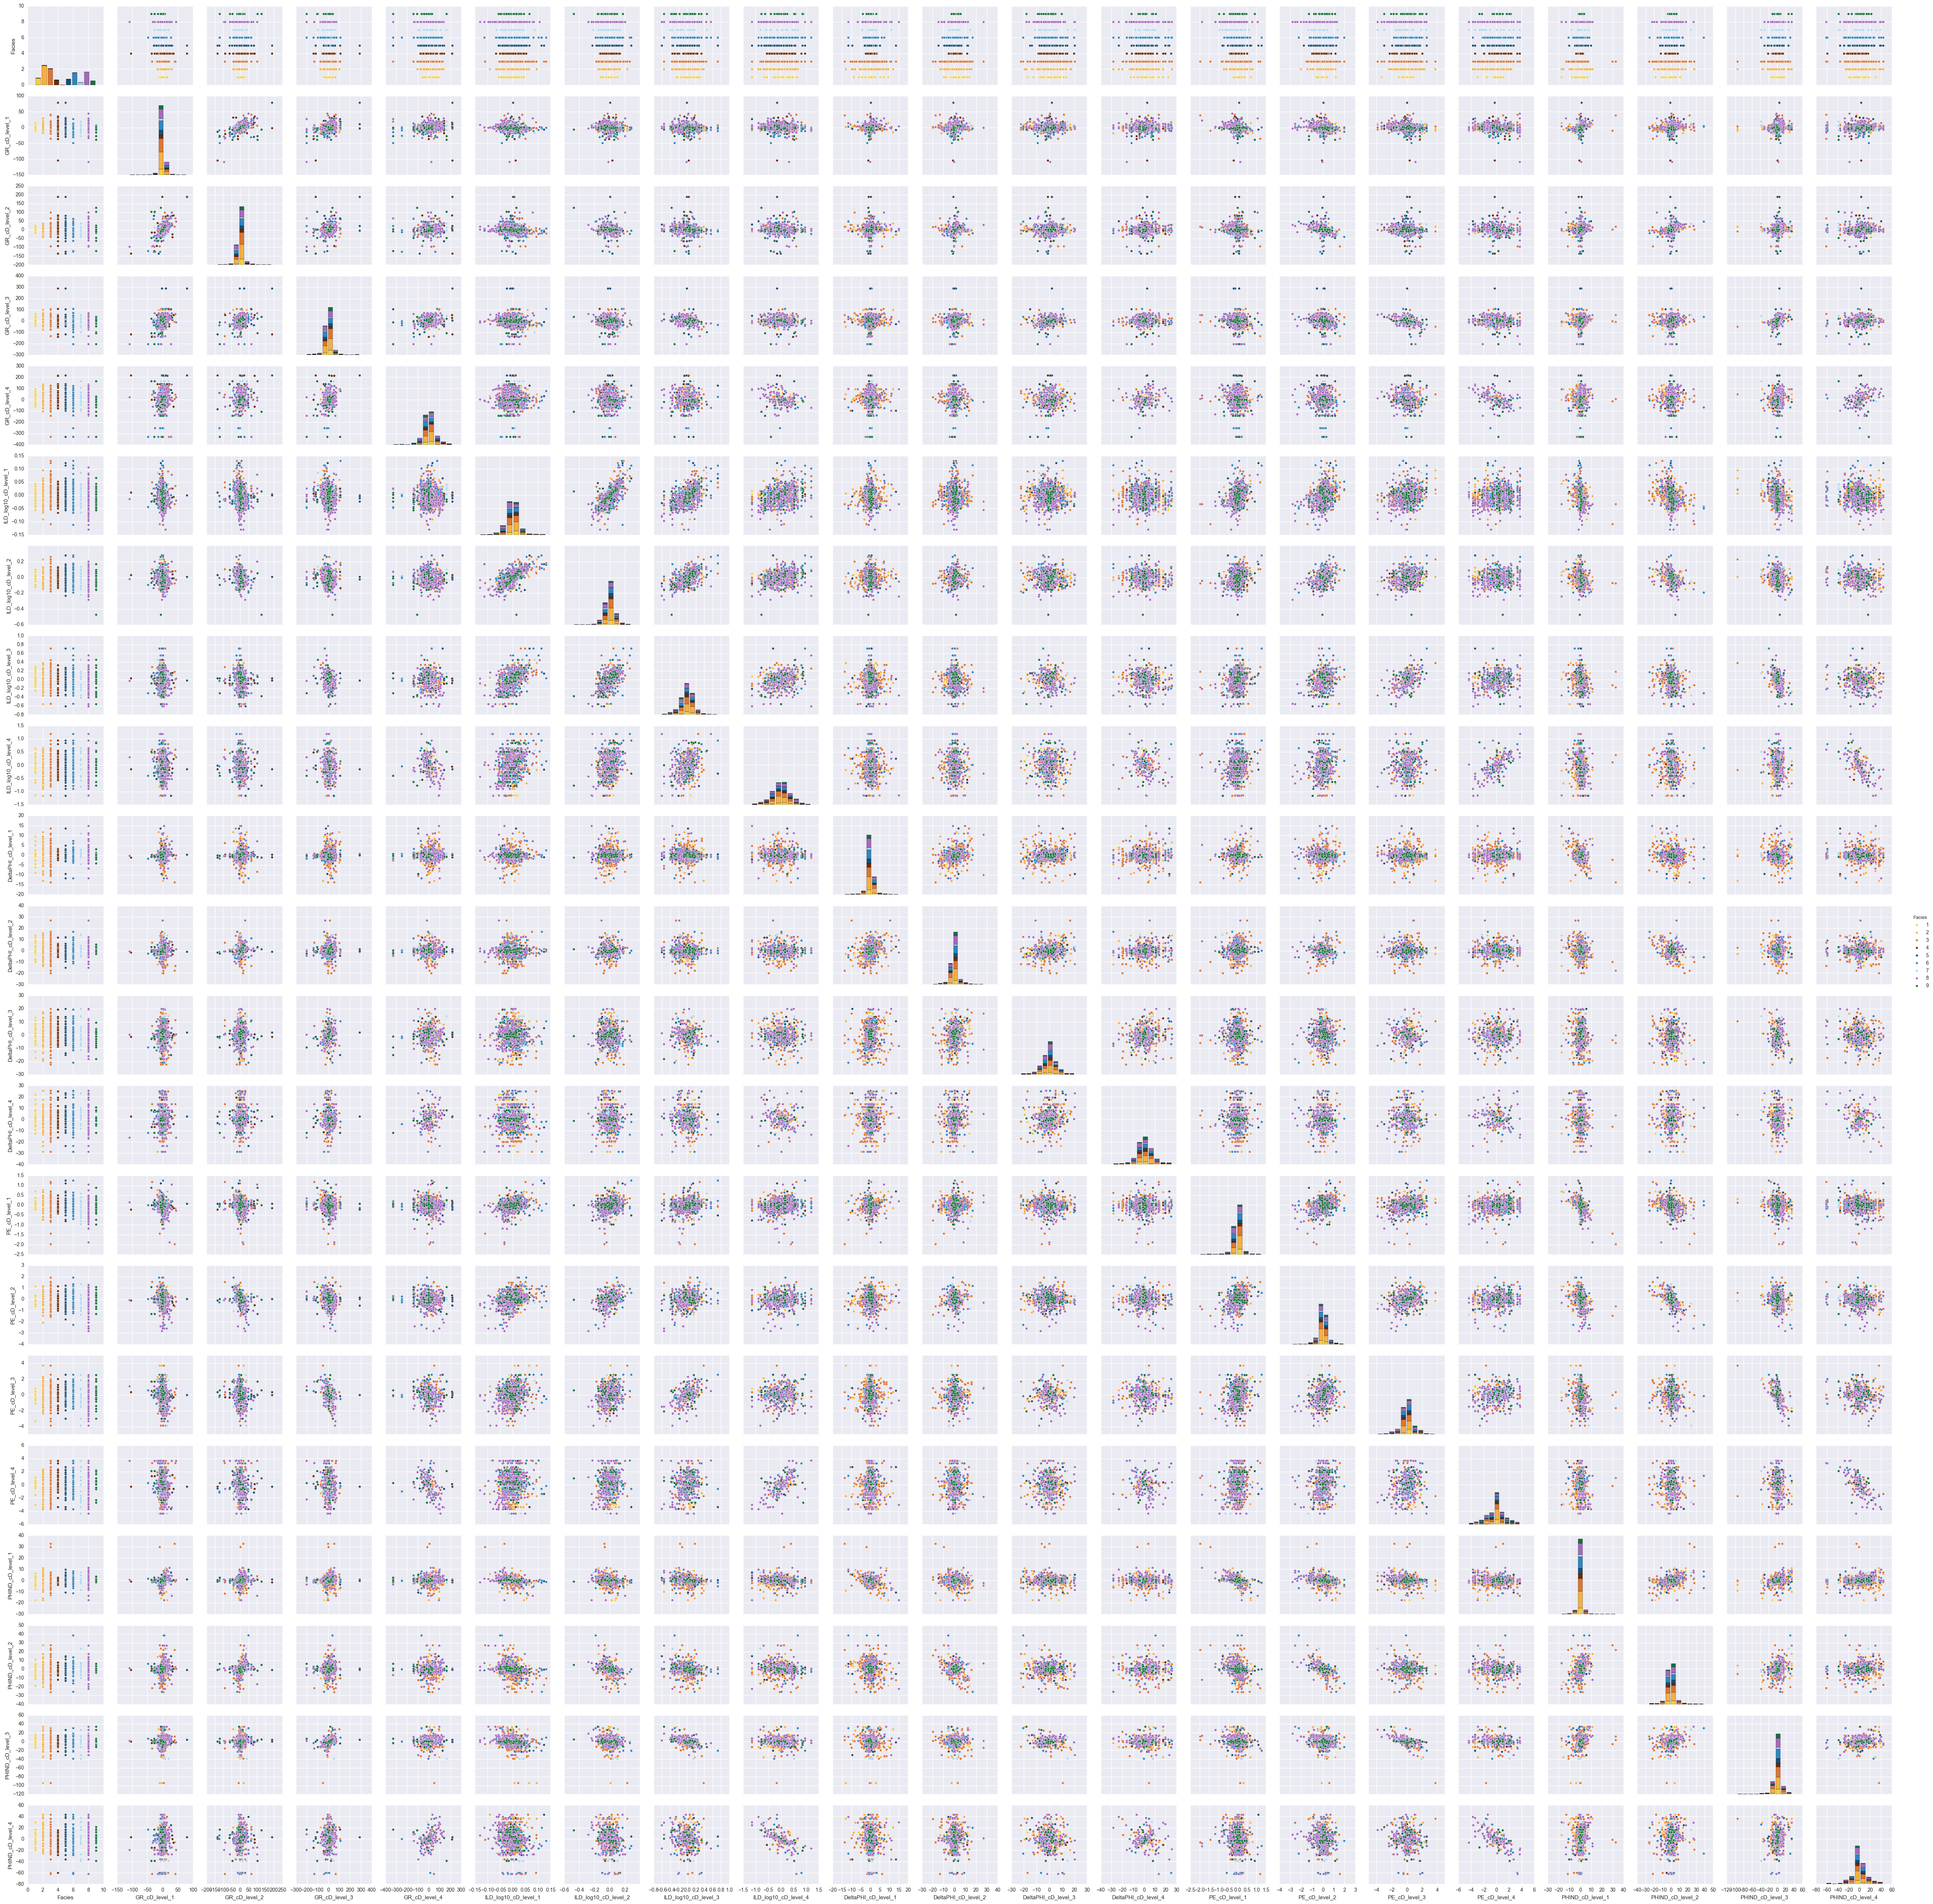

In [91]:
sns.set()
temp_df = dwt_db1_df
temp_df = temp_df.drop(['Formation', 'Well Name', 'Depth'], axis=1)
temp_df.dropna(inplace=True)
sns.pairplot(temp_df, hue='Facies', palette = flatui)

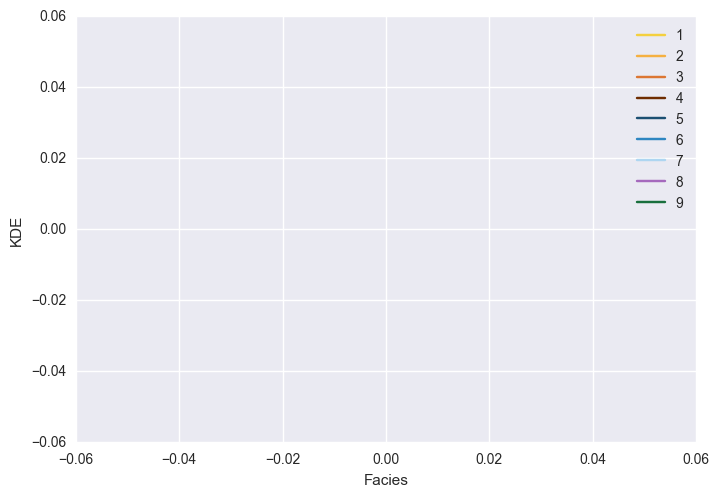

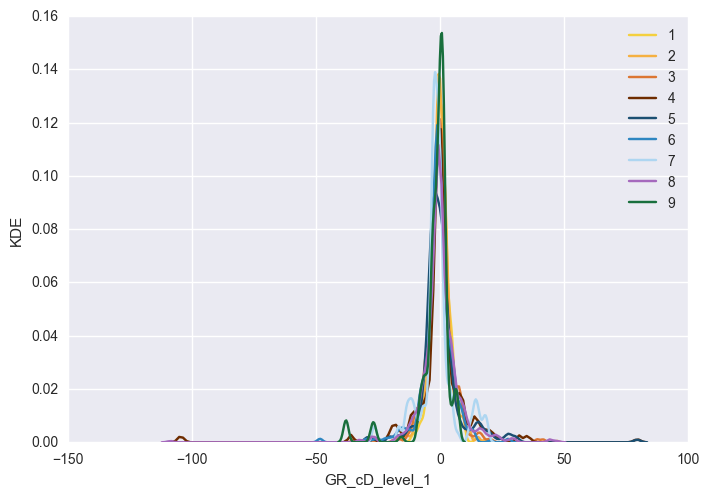

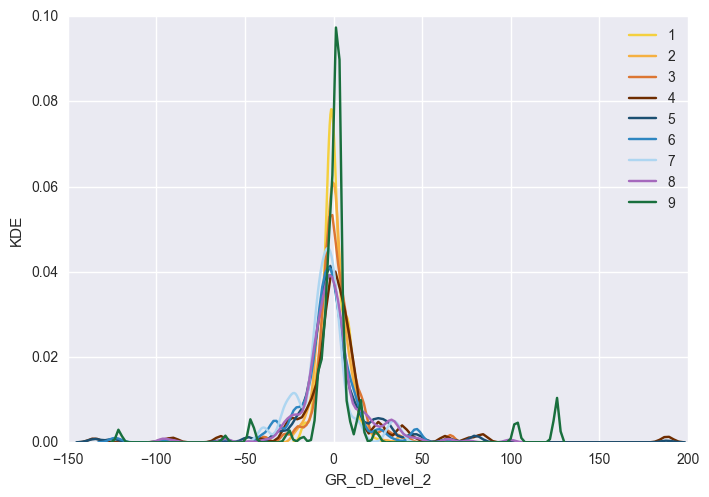

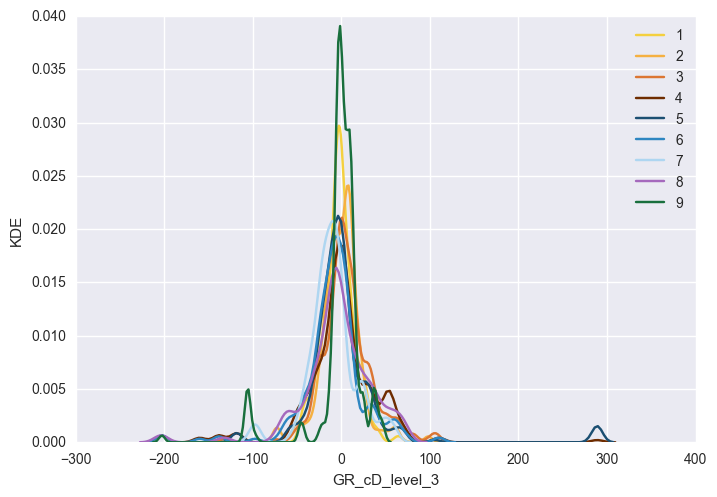

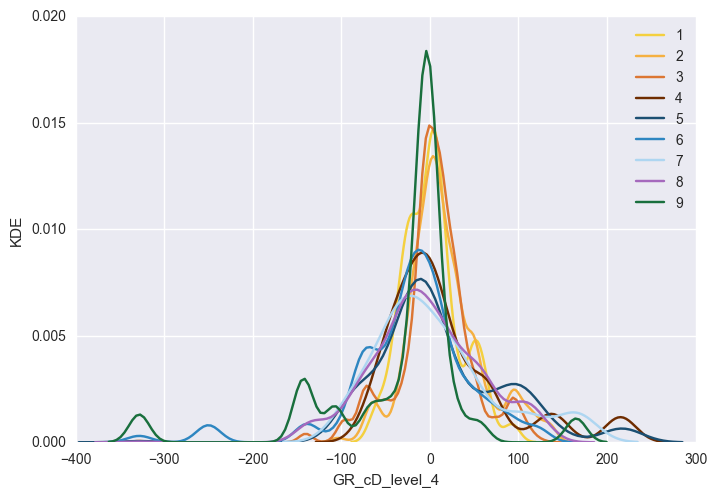

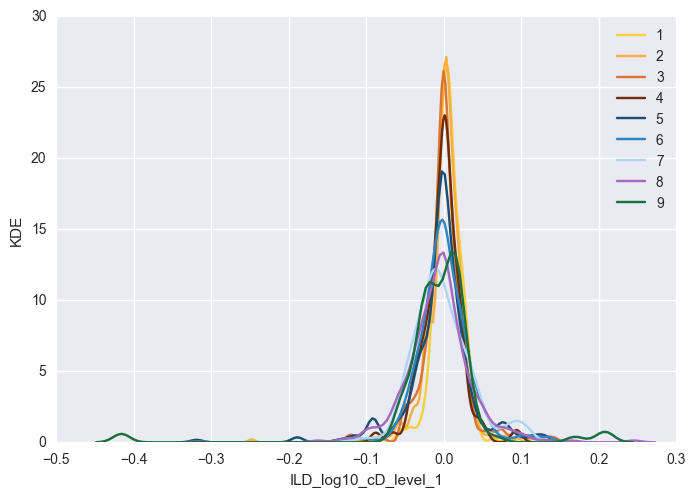

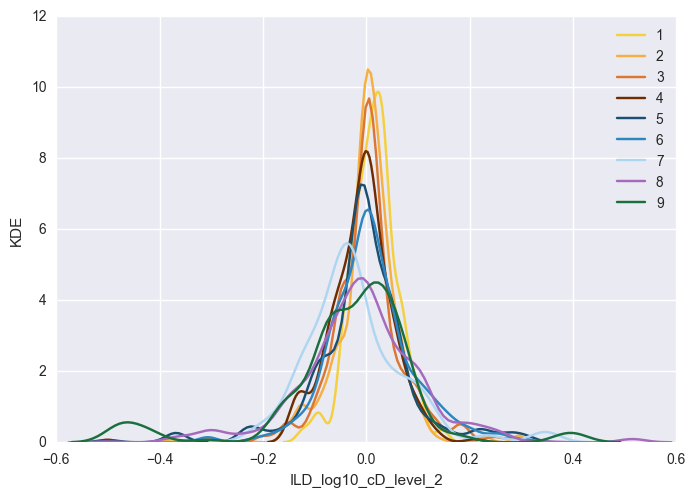

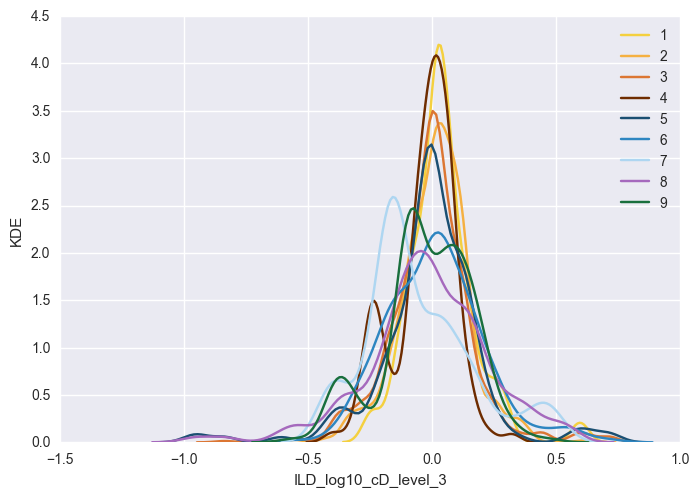

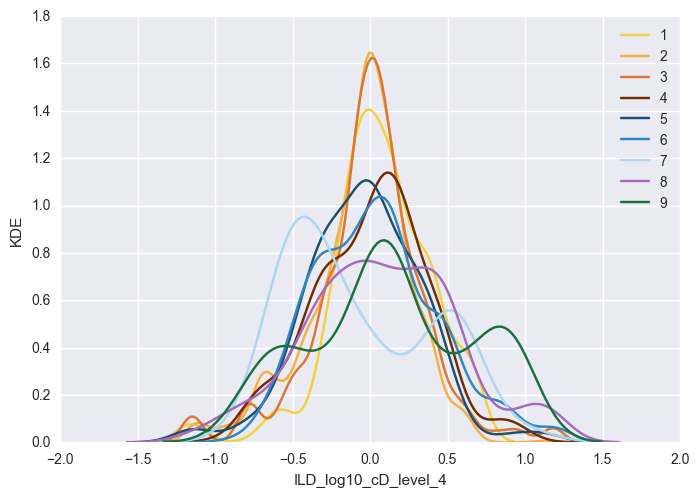

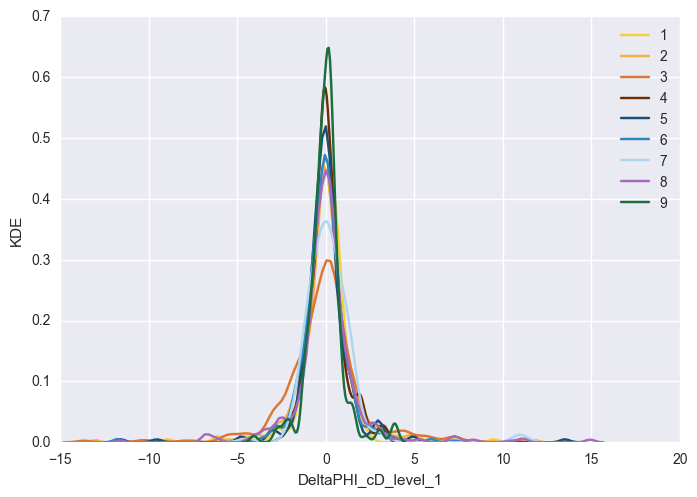

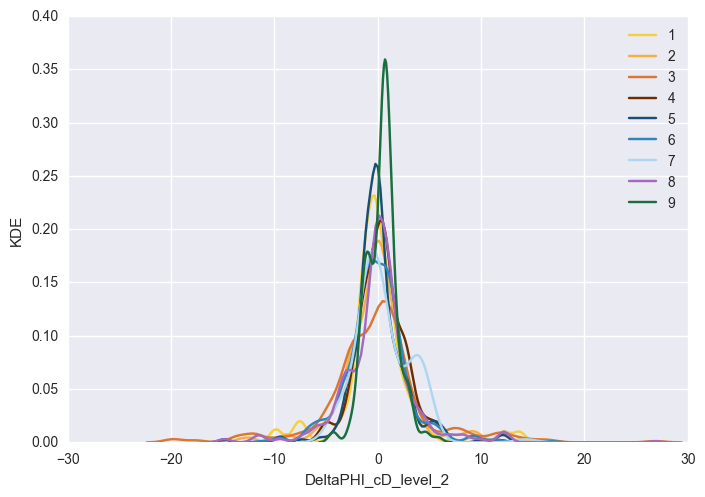

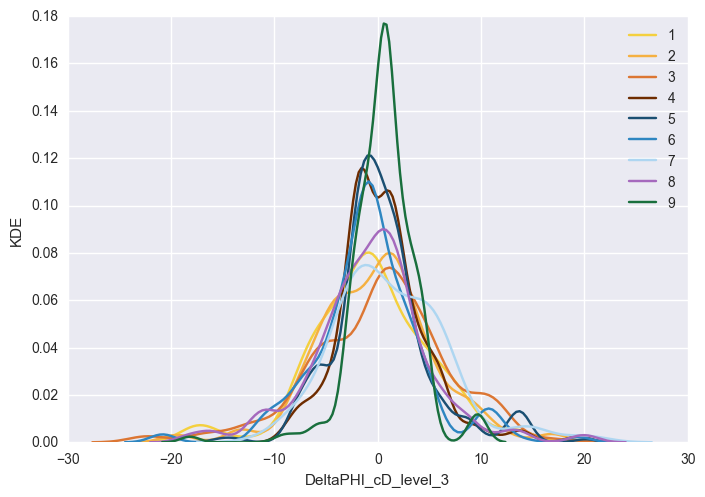

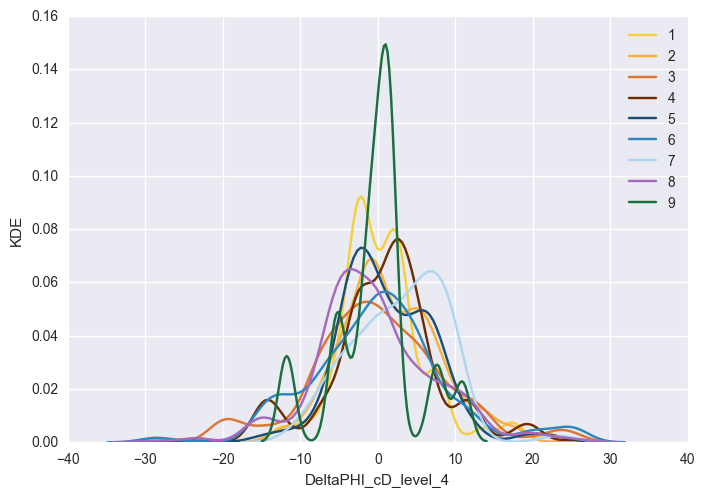

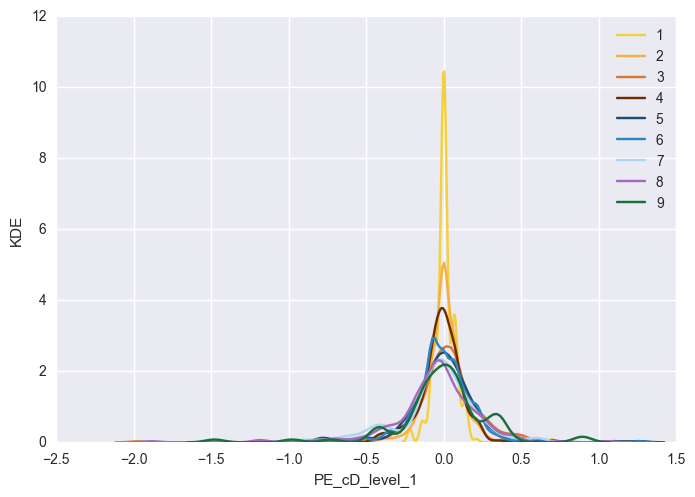

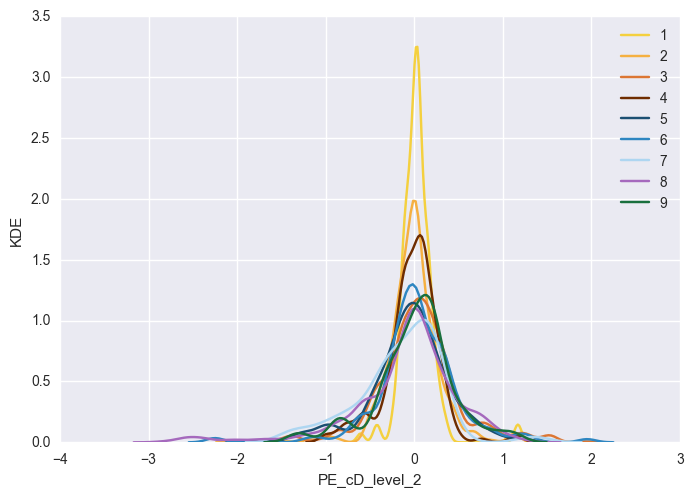

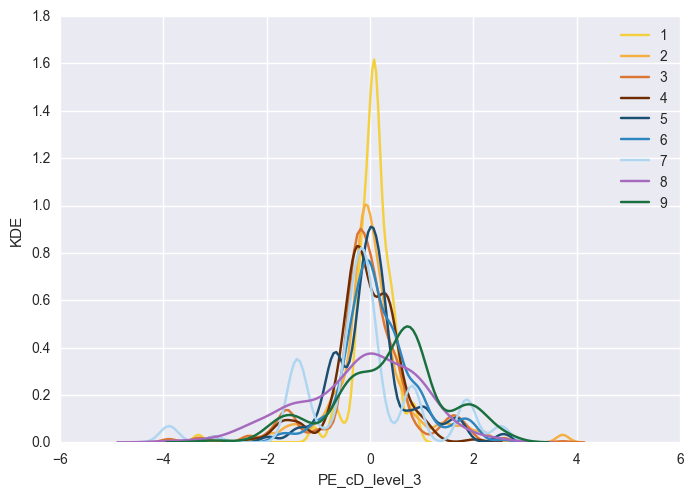

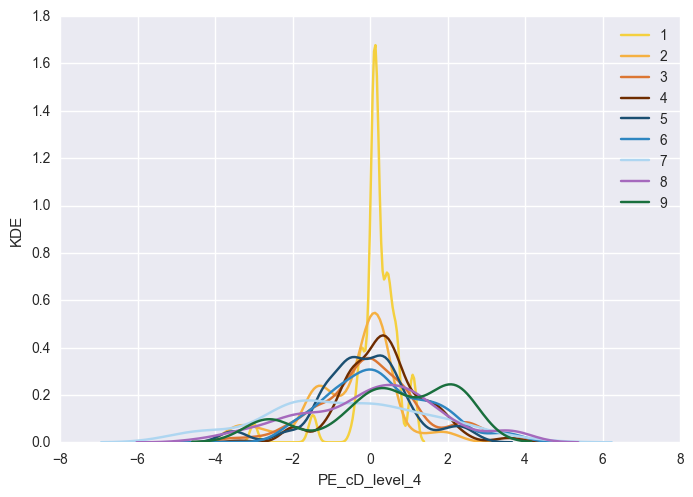

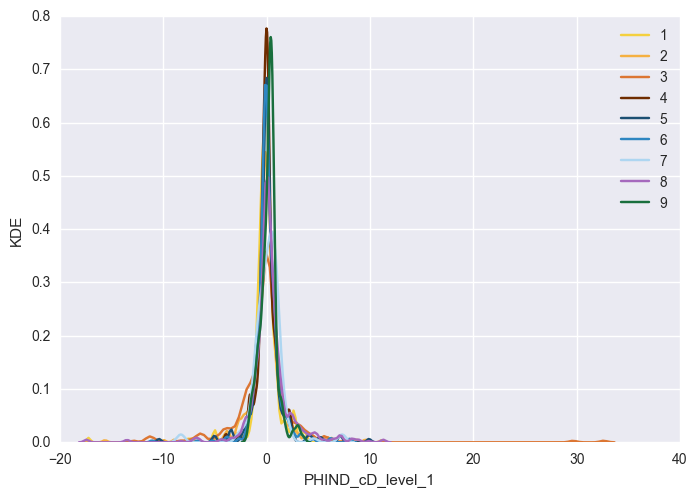

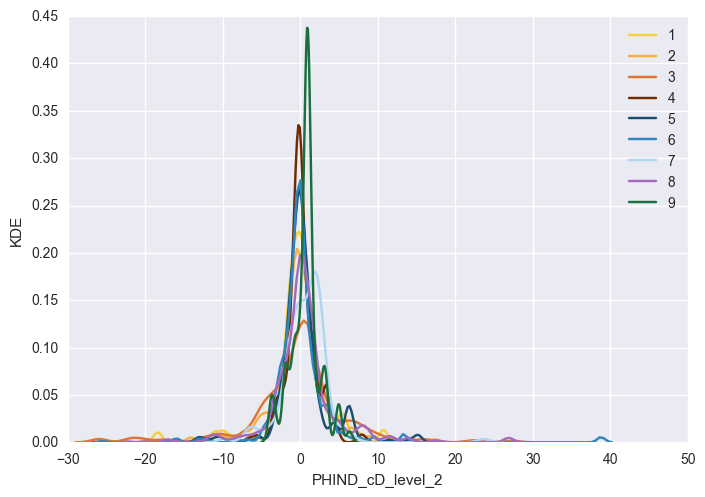

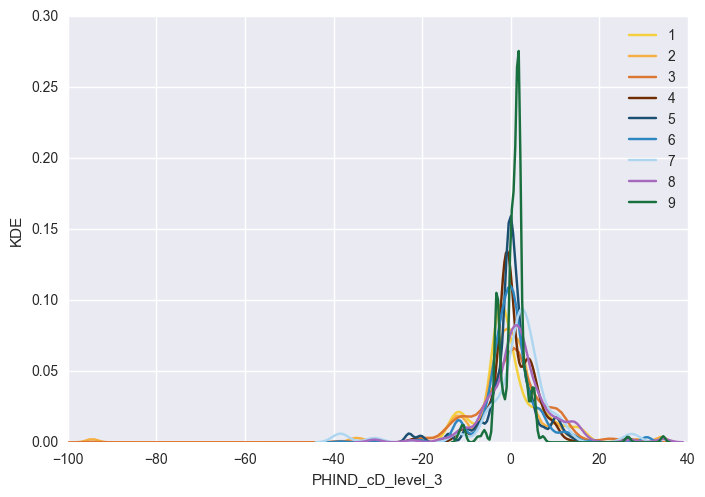

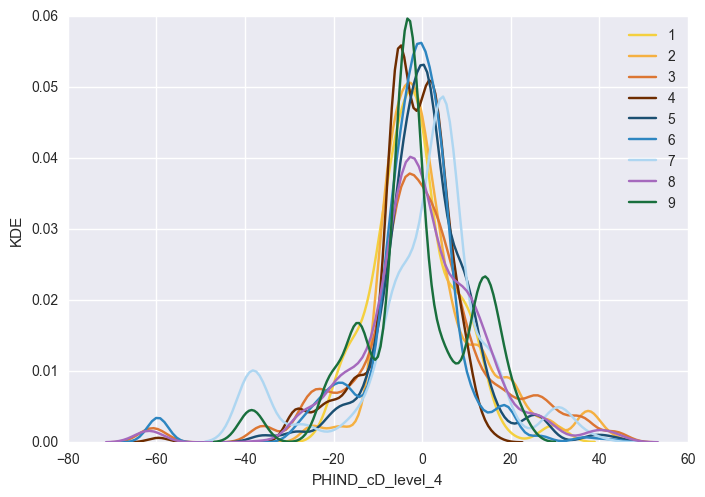

In [92]:
sns.set_palette(flatui)
list_variables = list(dwt_db1_df.columns.values)
list_variables.remove('Formation')
list_variables.remove('Well Name')
list_variables.remove('Depth')
#list_variables = ['GR_cD_step_level_1', 'GR_cA_step_level_1', 'GR_cD_step_level_2', 'GR_cA_step_level_2', 'GR_cD_step_level_3', 'GR_cA_step_level_3']
for a in list_variables:
    for i in np.arange(1, 10, 1):
        sns.kdeplot(dwt_db1_df[a][dwt_db1_df['Facies'] == i], label=i)
    plt.xlabel(a)
    plt.ylabel('KDE')
    plt.show()